# Analysis of Apple Support Tweets

## Team: Mira Daya, Misha Khan, Peggy Lee, Yashmini Vuppu, Ankit Jain

In [1]:
import os
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore")
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from tqdm._tqdm_notebook import tqdm_notebook
import re
#!pip install tweet-preprocessor
import preprocessor as p
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
tqdm_notebook.pandas()
import string
import nltk
from sklearn.decomposition import NMF, LatentDirichletAllocation
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import warnings
import pyLDAvis.gensim_models
import spacy
from pprint import pprint
warnings.filterwarnings("ignore",category=DeprecationWarning)
#nltk.download('punkt')
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob.sentiments import NaiveBayesAnalyzer, PatternAnalyzer
from textblob import Blobber
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns
os.chdir('/Users/jaina/Downloads/')
plt.rcParams['font.size'] = 14.0

C:\Users\jaina\AppData\Roaming\Python\Python38\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:18: DeprecationWarning: Call to deprecated create function FileDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  DESCRIPTOR = _descriptor.FileDescriptor(
C:\Users\jaina\AppData\Roaming\Python\Python38\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:36: DeprecationWarning: Call to deprecated create function FieldDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  _descriptor.FieldDescriptor(
C:\Users\jaina\AppData\Roaming\Python\Python38\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:43: DeprecationWarning: Call to deprecated create function FieldDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from genera

In [2]:
df = pd.read_csv('NLP-ProjectDataFinal.csv')

In [3]:
def dateCreator(text):
    return datetime.strftime(datetime.strptime(text,'%a %b %d %H:%M:%S +0000 %Y'), '%Y-%m-%d %H:%M:%S')

In [4]:
df = df[['author_id','created_at', 'text']]
df['created_at'] = df['created_at'].progress_apply(dateCreator)

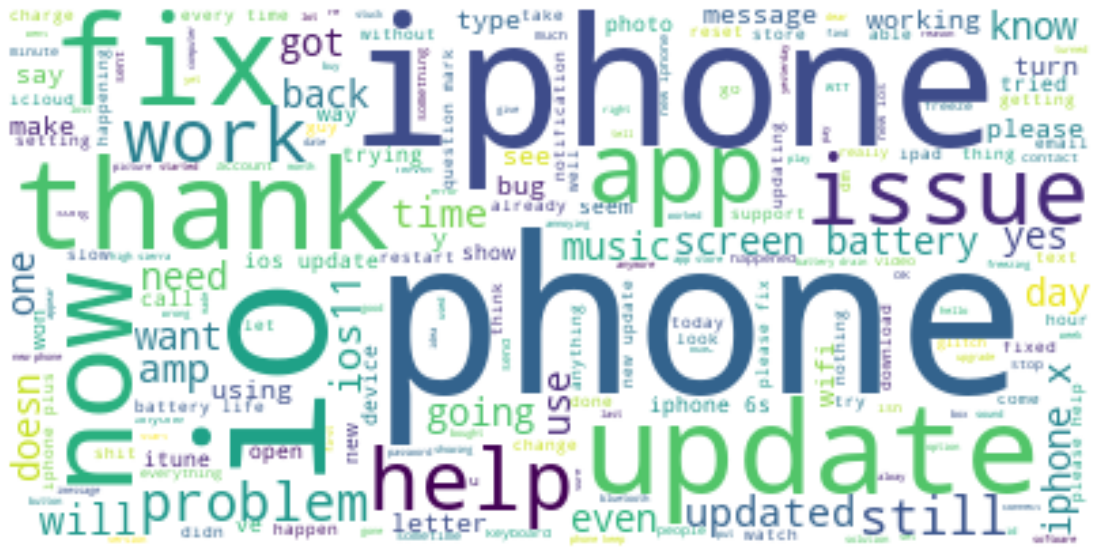

In [5]:
# Word Cloud for non-processed data
stopwords = set(STOPWORDS)
stopwords.update(['AppleSupport', 'https', 'apple', 't', 's', 'hi', 'ye', 'don', 'm', 'i', 'co', 'hey'])
text = " ".join(tweet.lower() for tweet in df.text)
plt.figure(figsize=(20,10))
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [6]:
# Removing Emojis, Mentions and URLs from tweets
df['Clean'] = df.progress_apply(lambda x: p.clean(str(x['text'])), axis = 1)
df = df[df['Clean'] != ''].reset_index(drop = True)

In [7]:
# Removing Digits
df['Clean'] = df['Clean'].astype(str).str.replace('\d+', '')

In [8]:
# Changing all text to lowercase
df['Clean'] = df['Clean'].str.lower()

In [9]:
# Removing Punctuations
def puncRemover(text):
    to_return = []
    for word in text.split():
        updatedWord = re.sub(r'[^\w\s]', '', word)
        if len(updatedWord) > 0:
            to_return.append(updatedWord)
    return ' '.join(to_return)
    
df['Clean'] = df.progress_apply(lambda x: puncRemover(x['Clean']), axis = 1)

In [10]:
# Removing Stop Words
stopwords = set(STOPWORDS)
stopwords = stopwords.union({'please', 'help', 'doesnt', 'fix', 'wont', 'let', 'much', 'fixed', 'appreciated'
                             'work', 'dm', 'sent', 'shit', 'whats', 'hey', 'going', 'thank', 'okay', 'ok', 'thank'
                             'much', 'reply', 'worked', 'fixed', 'boxes', 'work', 'either', 'will', 'should',
                             'details', 'question', 'mark', 'every', 'nope', 'ive', 'didnt', 'still', 'now',
                             'time', 'type', 'im', 'isnt', 'letter', 'didnt', 'work', 'yeah', 'thanks', 'yes',
                             'still', 'thank', 'appreciate', 'everytime', 'hi', 'guys', '&amp', 
                             'help', 'cant', 'got', 'guy', 'seem', 'yall', 'way', 'right', 'hour'})

def stopRemover(text):
    to_return = []
    for word in text.split():
        if word not in stopwords:
            if len(word) >= 3:
                to_return.append(word)
    return ' '.join(to_return)
df['Clean'] = df.progress_apply(lambda x: stopRemover(x['Clean']), axis = 1)

In [11]:
# Removing only one word or empty tweets
df['CleanLength'] = df.progress_apply(lambda x: len(x['Clean'].split()), axis = 1)
df = df[df['CleanLength'] > 1].reset_index(drop = True)
df = df[['author_id', 'created_at', 'text', 'Clean']]

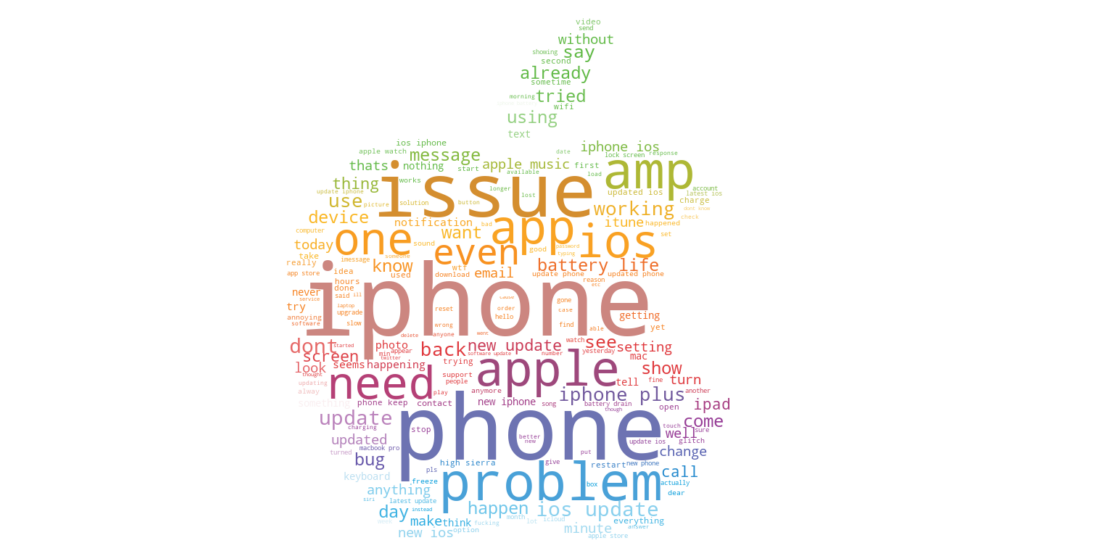

In [12]:
# Word Cloud for cleaned data
text = " ".join(tweet.lower() for tweet in df.Clean)
mask = np.array(Image.open("apple_logo.jpeg"))
image_colours = ImageColorGenerator(mask) # to make rainbow apple logo
plt.figure(figsize=(20,10))
wordcloud = WordCloud(prefer_horizontal = 1, stopwords=stopwords, mask = mask, color_func=image_colours, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [15]:
df["DateTime"] = pd.to_datetime(df["created_at"])
df["Year"] = df["DateTime"].dt.year
df["Month"] = df["DateTime"].dt.month
df["Weekday"] = df["DateTime"].dt.weekday
df["Hour"] = df["DateTime"].dt.hour

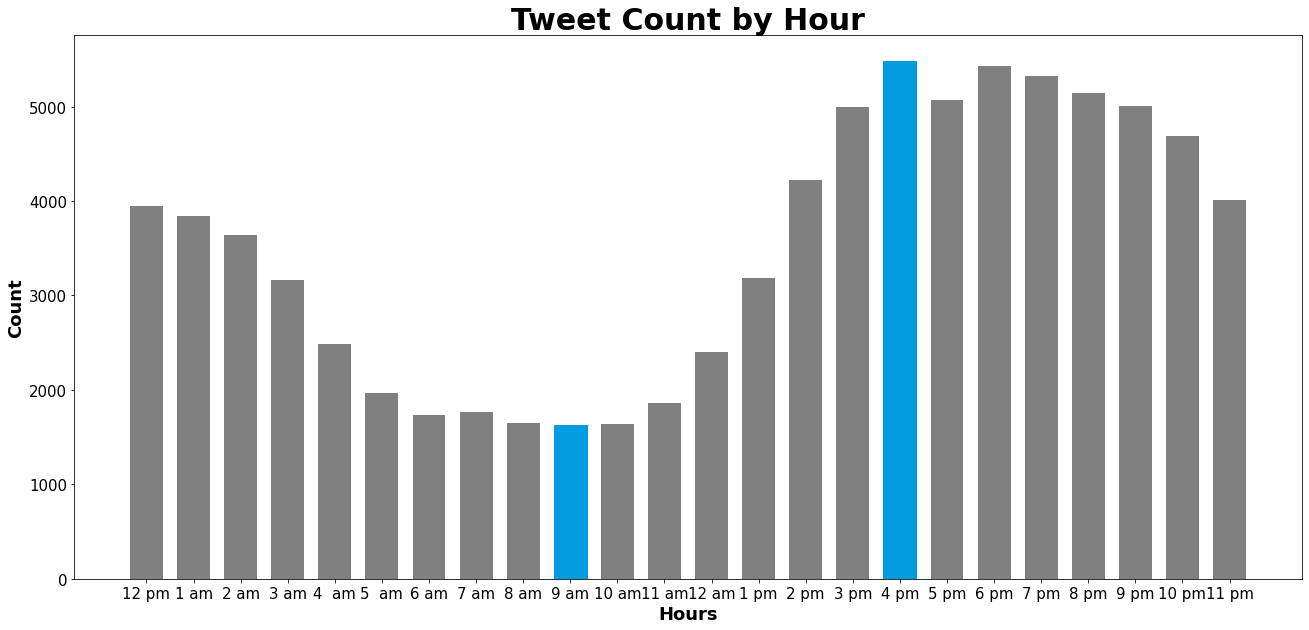

In [16]:
rvcnth = pd.DataFrame(df.groupby("Hour", as_index = False)["Hour"].count())
rvcnth = rvcnth.rename(columns = {"Hour": "Count"})
rvcnth["Hour"] = ['12 pm', '1 am', '2 am', '3 am', '4  am', '5  am', '6 am', '7 am', '8 am', '9 am', '10 am', '11 am', '12 am', '1 pm', '2 pm', '3 pm', '4 pm', '5 pm', '6 pm', '7 pm', '8 pm', '9 pm', '10 pm', '11 pm']

# Barplot
plt.figure(figsize = (22,10))

barplot = plt.bar(rvcnth["Hour"], rvcnth["Count"], color = "grey", width = 0.7)
barplot[9].set_color('#009CDF')
barplot[16].set_color('#009CDF')

plt.title('Tweet Count by Hour', fontsize = 30, weight = "bold")
plt.xlabel('Hours', fontsize = 18, weight = "bold")
plt.ylabel('Count', fontsize = 18, weight = "bold")
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
#plt.xticks(rotation=90)

plt.show()

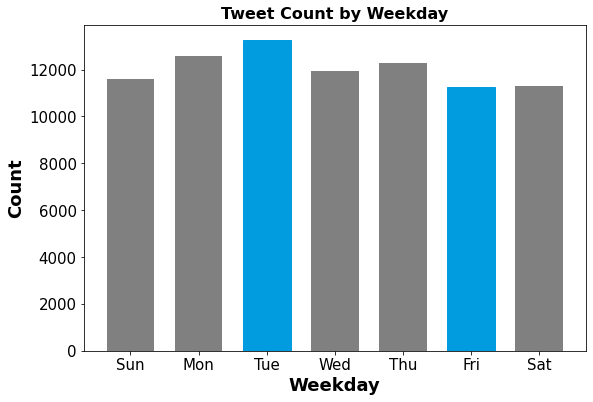

In [17]:
reviewsbyweekday = pd.DataFrame(df.groupby("Weekday", as_index = False)["Weekday"].count())
reviewsbyweekday = reviewsbyweekday.rename(columns = {"Weekday": "Count"})
reviewsbyweekday["Weekday"] = ["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"]

# Barplot
plt.figure(figsize = (9, 6))
barplot = plt.bar(reviewsbyweekday["Weekday"], reviewsbyweekday["Count"], color = "grey", width = 0.7)
barplot[2].set_color('#009CDF')
barplot[5].set_color('#009CDF')

plt.title('Tweet Count by Weekday', fontsize = 16, weight = "bold")
plt.xlabel('Weekday', fontsize = 18, weight = "bold")
plt.ylabel('Count', fontsize = 18, weight = "bold")
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

In [18]:
# Avg tweets per person
sum(df.author_id.value_counts()) / len(df.author_id.value_counts())

1.562182411631616

## Text Analysis

In [19]:
stemmer = PorterStemmer()
def stemTokenizer(text):
    return [stemmer.stem(item) for item in list(word_tokenize(word) for word in sent_tokenize(text))[0]]

In [82]:
def printTopics(model, featureNames, n_top_words):
    for index, topic in enumerate(model.components_):
        print('Topic {}: '.format(index + 1) + ' '.join([featureNames[i] for i in topic.argsort()[:-n_top_words - 1 :-1]]))
        #print('\n')

In [21]:
df['Stemmed'] = df.progress_apply(lambda x: stemTokenizer(x['Clean']), axis = 1)

In [22]:
tfidf = TfidfVectorizer(min_df = 2, max_df = 0.8, ngram_range=(1, 1))
tfidf.fit_transform(df['Clean'].values)
tfidf_table = pd.DataFrame(columns=['tfidf']).from_dict(dict(zip(tfidf.get_feature_names(), tfidf.idf_)), orient='index')
tfidf_table.columns = ['tfidf']
tfidf_table = tfidf_table.sort_values(by = ['tfidf'], ascending = True)
tfidf_table.head(10)

,tfidf
iphone,2.707482
ios,2.786113
phone,2.795077
update,3.116456
apple,3.428243
battery,3.637551
new,3.649739
app,3.948400
screen,4.097581
updated,4.142475


In [23]:
tfidf = TfidfVectorizer(min_df = 2, max_df = 0.8, ngram_range=(2, 2))
tfidf.fit_transform(df['Clean'].values)
tfidf_table = pd.DataFrame(columns=['tfidf']).from_dict(dict(zip(tfidf.get_feature_names(), tfidf.idf_)), orient='index')
tfidf_table.columns = ['tfidf']
tfidf_table = tfidf_table.sort_values(by = ['tfidf'], ascending = True)
tfidf_table.head(10)

,tfidf
iphone plus,4.908906
ios update,4.963631
battery life,5.175124
new update,5.360384
apple music,5.419731
new ios,5.500843
iphone ios,5.534560
new iphone,5.624795
updated ios,5.675706
high sierra,5.689818


In [24]:
tfidf = TfidfVectorizer(min_df = 2, max_df = 0.8, ngram_range=(3, 3))
tfidf.fit_transform(df['Clean'].values)
tfidf_table = pd.DataFrame(columns=['tfidf']).from_dict(dict(zip(tfidf.get_feature_names(), tfidf.idf_)), orient='index')
tfidf_table.columns = ['tfidf']
tfidf_table = tfidf_table.sort_values(by = ['tfidf'], ascending = True)
tfidf_table.head(10)

,tfidf
new ios update,6.728261
latest ios update,7.068390
iphone plus ios,7.188098
phone keeps freezing,7.291534
macos high sierra,7.385562
brand new iphone,7.596457
apple watch series,7.650042
ios iphone plus,7.659258
apple pay cash,7.746270
low power mode,7.819601


In [25]:
tfidf = TfidfVectorizer(min_df = 2, max_df = 0.8, ngram_range=(4, 4))
tfidf.fit_transform(df['Clean'].values)
tfidf_table = pd.DataFrame(columns=['tfidf']).from_dict(dict(zip(tfidf.get_feature_names(), tfidf.idf_)), orient='index')
tfidf_table.columns = ['tfidf']
tfidf_table = tfidf_table.sort_values(by = ['tfidf'], ascending = True)
tfidf_table.head(10)

,tfidf
check overall battery health,8.730472
overall battery health iphone,8.815029
check battery health iphone,8.907402
iphone plus running ios,9.296867
updated phone last night,9.396951
new ios update phone,9.396951
update phone keeps freezing,9.396951
battery health iphone plus,9.508176
ios phone keeps freezing,9.568801
latest ios update iphone,9.568801


In [26]:
tfidf = TfidfVectorizer(min_df = 2, max_df = 0.8, ngram_range=(2, 4))
tfidf.fit_transform(df['Clean'].values)
tfidf_table = pd.DataFrame(columns=['tfidf']).from_dict(dict(zip(tfidf.get_feature_names(), tfidf.idf_)), orient='index')
tfidf_table.columns = ['tfidf']
tfidf_table = tfidf_table.sort_values(by = ['tfidf'], ascending = True)
tfidf_table.head(10)

,tfidf
iphone plus,4.908906
ios update,4.963631
battery life,5.175124
new update,5.360384
apple music,5.419731
new ios,5.500843
iphone ios,5.534560
new iphone,5.624795
updated ios,5.675706
high sierra,5.689818


## Topic Modelling

In [83]:
tfidf = TfidfVectorizer(min_df = 2, max_df = 0.8, ngram_range = (2, 4))
tfidf.fit_transform(df['Clean'].values)
#NMFModel = NMF(init = "nndsvd", n_components = 10, max_iter=200, random_state=0)
NMFModel = NMF(init = "nndsvd", n_components = 10, max_iter=200, random_state=0)
NMFModel.fit_transform(tfidf.fit_transform(df['Clean'].values)) 
#printTopics(NMFModel, tfidf.get_feature_names(), 10)
printTopics(NMFModel, tfidf.get_feature_names(), 1)

Topic 1: iphone plus
Topic 2: iphone ios
Topic 3: ios update
Topic 4: apple music
Topic 5: ios iphone
Topic 6: new update
Topic 7: high sierra
Topic 8: plus ios
Topic 9: battery life
Topic 10: updated ios


In [28]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [29]:
data_words = list(sent_to_words(df.Clean.to_list()))
bigram = gensim.models.Phrases(data_words, min_count=2, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

data_words_bigrams = make_bigrams(data_words)

In [30]:
nlp = spacy.load("en_core_web_sm")

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [31]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [86]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, # 5, 10, 25
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis


Perplexity:  -7.917387350338323

Coherence Score:  0.2541281575790699


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.444381 -0.027290       1        1  20.136561
5     -0.015630  0.383280       2        1  13.454080
2      0.000249 -0.272090       3        1  12.839724
0      0.040584  0.006166       4        1  10.796716
9      0.063738 -0.013929       5        1   8.282739
7      0.071321 -0.019528       6        1   8.096787
8      0.069108 -0.017800       7        1   7.499536
4      0.073595 -0.020520       8        1   7.117847
3      0.067402 -0.008373       9        1   7.068577
6      0.074014 -0.009917      10        1   4.707433, topic_info=         Term          Freq         Total Category  logprob  loglift
11      phone  16514.000000  16514.000000  Default  30.0000  30.0000
16     iphone  18757.000000  18757.000000  Default  29.0000  29.0000
4      update  15015.000000  15015.000000  Default  28.0000  28.0000
72      apple   8806.000000   8806.000000  Default  27.0000  27.0000
20        app   8100.000000   8100.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
153      help    249.534680    250.341803  Topic10  -4.7579   3.0528
70        air    249.075683    249.882789  Topic10  -4.7597   3.0528
1034     hate    239.542334    240.349499  Topic10  -4.7988   3.0527
69    youtube    239.220362    240.027492  Topic10  -4.8001   3.0527
1021  provide    228.592709    229.399887  Topic10  -4.8456   3.0525

[330 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
83        7  0.998881       able
368       8  0.999283     access
359       8  0.999777    account
1147     10  0.996627   activate
421       5  0.999156   actually
...     ...       ...        ...
315       9  0.999277        wtf
367       3  0.999496       year
5         1  0.999209  yesterday
446       7  0.998152        yet
69       10  0.995719    youtube

[300 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 3, 1, 10, 8, 9, 5, 4, 7])

In [87]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis


Perplexity:  -7.4056700927265044

Coherence Score:  0.2405731550131318


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.413525 -0.010691       1        1  39.738350
2      0.114138 -0.386986       2        1  23.765624
3      0.100420  0.151142       3        1  13.765595
0      0.103219  0.129273       4        1  12.040191
4      0.095748  0.117262       5        1  10.690239, topic_info=       Term          Freq         Total Category  logprob  loglift
16   iphone  16307.000000  16307.000000  Default  30.0000  30.0000
72    apple   7943.000000   7943.000000  Default  29.0000  29.0000
11    phone  16179.000000  16179.000000  Default  28.0000  28.0000
4    update  13968.000000  13968.000000  Default  27.0000  27.0000
262     use   5719.000000   5719.000000  Default  26.0000  26.0000
..      ...           ...           ...      ...      ...      ...
79   always    597.583290    598.283013   Topic5  -4.7048   2.2347
853     pop    569.972930    570.680111   Topic5  -4.7521   2.2346
436     ill    558.680352    559.379319   Topic5  -4.7721   2.2346
46   recent    546.243667    546.946675   Topic5  -4.7946   2.2346
878  safari    538.522793    539.226920   Topic5  -4.8089   2.2345

[180 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
83        4  0.999529      able
359       4  0.999310   account
421       4  0.998276  actually
482       3  0.999444       ago
354       4  0.999441   already
...     ...       ...       ...
281       4  0.999605      well
280       1  0.999410      wifi
632       3  0.999464      word
51        1  0.999849      work
446       4  0.998679       yet

[150 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 1, 5])

In [88]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, # 5, 10, 25
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis


Perplexity:  -7.2941022722015685

Coherence Score:  0.2768282042923937


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.352451 -0.076267       1        1  49.119674
2      0.245799 -0.251634       2        1  32.357339
0      0.106652  0.327901       3        1  18.522987, topic_info=          Term          Freq         Total Category  logprob  loglift
72       apple   7807.000000   7807.000000  Default  30.0000  30.0000
16      iphone  16735.000000  16735.000000  Default  29.0000  29.0000
11       phone  15518.000000  15518.000000  Default  28.0000  28.0000
4       update  13397.000000  13397.000000  Default  27.0000  27.0000
103         io   9254.000000   9254.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
269  disappear    810.184603    811.142258   Topic3  -4.9501   1.6850
363     laptop    583.838670    584.548579   Topic3  -5.2777   1.6849
446        yet    591.719613    592.450000   Topic3  -5.2643   1.6849
617     backup    577.499387    578.221338   Topic3  -5.2887   1.6849
452     unlock    677.576147    678.457430   Topic3  -5.1289   1.6849

[123 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
83        3  0.999071     able
359       3  0.999749  account
482       3  0.999004      ago
71        3  0.999608      amp
20        1  0.999876      app
...     ...       ...      ...
280       1  0.990955     wifi
280       2  0.008587     wifi
51        2  0.999719     work
367       3  0.999457     year
446       3  0.999240      yet

[94 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

In [35]:
# Num_Topics = 3 is best
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.068*"apple" + 0.024*"music" + 0.022*"amp" + 0.018*"want" + 0.016*"charge" '
  '+ 0.015*"store" + 0.015*"itune" + 0.014*"buy" + 0.014*"account" + '
  '0.013*"month"'),
 (1,
  '0.055*"iphone" + 0.051*"phone" + 0.044*"update" + 0.031*"io" + 0.026*"app" '
  '+ 0.020*"new" + 0.019*"use" + 0.019*"issue" + 0.016*"battery" + '
  '0.013*"happen"'),
 (2,
  '0.028*"try" + 0.020*"work" + 0.020*"screen" + 0.019*"keep" + 0.017*"back" + '
  '0.016*"turn" + 0.014*"need" + 0.014*"day" + 0.014*"call" + 0.013*"restart"')]


In [36]:
def getDominantTopic(stemmedList):
    topics = list(lda_model.get_document_topics(id2word.doc2bow(stemmedList)))
    topic_dict = {0: 'Topic 1', 1: 'Topic 2', 2: 'Topic 3'}
    max_score = max([i[1] for i in topics])
    dom_topic = [i[0] for i in topics if i[1] == max_score]
    return topic_dict[dom_topic[0]]

In [37]:
df['Topic'] = df.progress_apply(lambda x: getDominantTopic(x['Stemmed']), axis = 1)

In [38]:
df['Date'] = pd.to_datetime(df['created_at'])
df = df.sort_values(by = 'Date').reset_index(drop = True)

Text(0, 0.5, 'Topic')

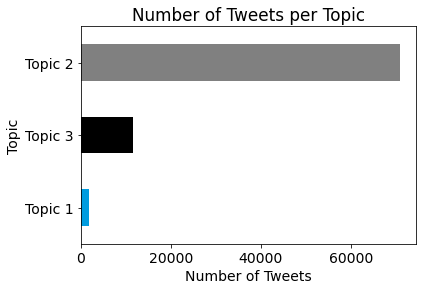

In [178]:
df['Topic'].value_counts().sort_values().plot(kind = 'barh', color = ['#009CDF', 'black', 'grey'])
plt.title('Number of Tweets per Topic')
plt.xlabel('Number of Tweets')
plt.ylabel('Topic')

Text(0.5, 1.0, 'Pie Chart showing Distribution of Topics')

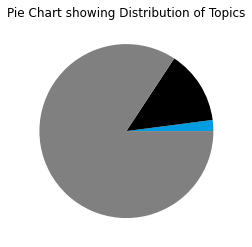

In [40]:
plt.pie(df['Topic'].value_counts().sort_values(),colors=['#009CDF', 'black', 'grey'])
plt.title('Pie Chart showing Distribution of Topics')

## Sentiment Analysis

In [41]:
textblob = Blobber(analyzer = PatternAnalyzer())
textblob2 = Blobber(analyzer = NaiveBayesAnalyzer())
vader = SentimentIntensityAnalyzer()

In [42]:
df2 = df.copy()
df['Month'] = df.progress_apply(lambda x: x['Date'].month, axis = 1)
df['Year'] = df.progress_apply(lambda x: x['Date'].year, axis = 1)
df = df[df['Year'] == 2017][df.Month >= 10].reset_index(drop = True)

In [43]:
def getPolarity(text):
    return textblob(text).sentiment.polarity

def getSubjectivity(text):
    return textblob(text).sentiment.subjectivity

def getNaiveSentiment(text):
    sentiment = textblob2(text).sentiment
    if sentiment.classification == 'neg':
        return 'Negative'
    elif sentiment.p_pos == sentiment.p_neg:
        return 'Neutral'
    else:
        return 'Positive'
    
def naivePos(text):
    return textblob2(text).sentiment.p_pos

def naiveNeg(text):
    return textblob2(text).sentiment.p_neg
    
def getPatternSentiment(polarity):
    if polarity < 0:
        return 'Negative'
    elif polarity == 0:
        return 'Neutral'
    else:
        return 'Positive'
    
def getVaderSentiment(text):
    sentiment = vader.polarity_scores(text)
    scores = [sentiment['neg'], sentiment['neu'], sentiment['pos']]
    
    if len(set(scores)) == 1:
        return 'Neutral'
    if max(scores) == sentiment['neg']:
        return 'Negative'
    elif max(scores) == sentiment['pos']:
        return 'Positive'
    elif max(scores) == sentiment['neu']:
        return 'Neutral'
    
def getCompound(text):
    return vader.polarity_scores(text)['compound']

def posVader(text):
    return vader.polarity_scores(text)['pos']

def negVader(text):
    return vader.polarity_scores(text)['neg']

def neuVader(text):
    return vader.polarity_scores(text)['neu']

def most_frequent(List):
    return max(set(List), key = List.count)

In [44]:
df['Polarity'] = df.progress_apply(lambda x: getPolarity(x['Clean']), axis = 1)
df['Subjectivity'] = df.progress_apply(lambda x: getSubjectivity(x['Clean']), axis = 1)
df['NaiveSentiment'] = df.progress_apply(lambda x: getNaiveSentiment(x['Clean']), axis = 1)
df['PatternSentiment'] = df.progress_apply(lambda x: getPatternSentiment(x['Polarity']), axis = 1)
df['VaderSentiment'] = df.progress_apply(lambda x: getVaderSentiment(x['Clean']), axis = 1)
df['Compound'] = df.progress_apply(lambda x: getCompound(x['Clean']), axis = 1)
df['PosVader'] = df.progress_apply(lambda x: posVader(x['Clean']), axis = 1)
df['NegVader'] = df.progress_apply(lambda x: negVader(x['Clean']), axis = 1)
df['NeuVader'] = df.progress_apply(lambda x: neuVader(x['Clean']), axis = 1)
df['PosNaive'] = df.progress_apply(lambda x: naivePos(x['Clean']), axis = 1)
df['NegNaive'] = df.progress_apply(lambda x: naiveNeg(x['Clean']), axis = 1)
df['CombinedSentiment'] = df.progress_apply(lambda x: [x['NaiveSentiment']] + [x['VaderSentiment']] + [x['PatternSentiment']], axis = 1)
df['FrequentSentiment'] = df.progress_apply(lambda x: most_frequent(x['CombinedSentiment']) , axis = 1)

In [173]:
def createBar(df, title, master_df):
    plt.figure(figsize = (9, 6))
    ax = df.plot(kind = 'bar', color = ['#009CDF', 'black', 'grey'])
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        ax.annotate('{}%'.format(round(height/master_df.shape[0]*100, 2)), (x + width/2, y + height*1.01), ha = 'center')
    plt.title(title)
    plt.show()

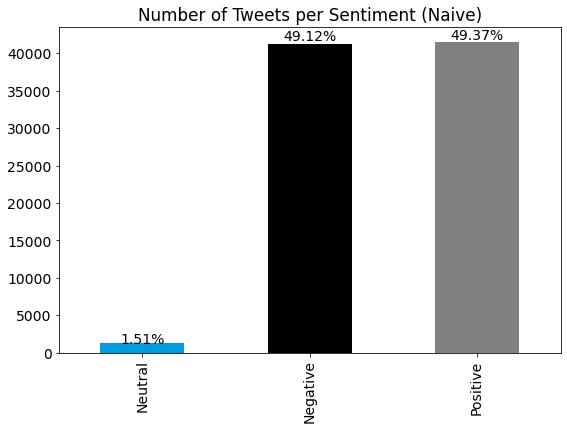

In [174]:
createBar(df['NaiveSentiment'].value_counts().sort_values(), 'Number of Tweets per Sentiment (Naive)', df)

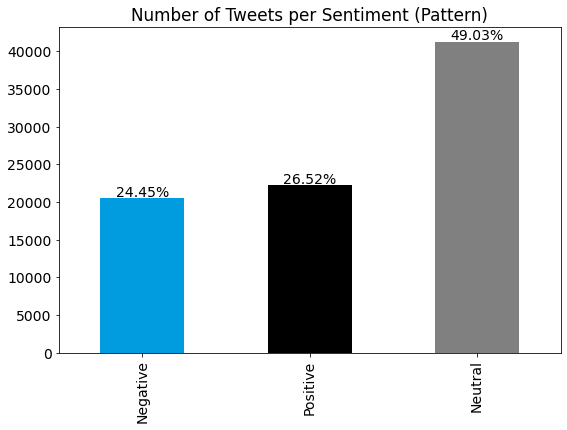

In [175]:
createBar(df['PatternSentiment'].value_counts().sort_values(), 'Number of Tweets per Sentiment (Pattern)', df)

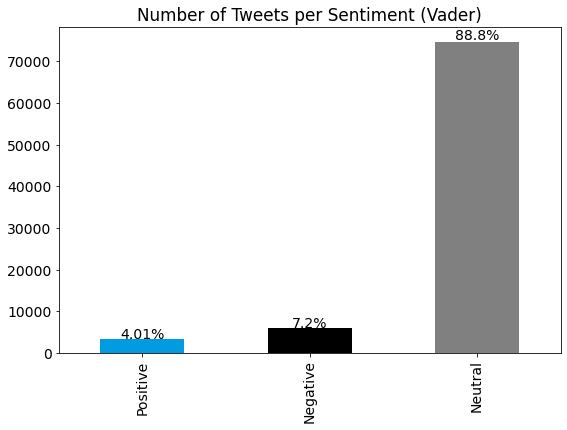

In [179]:
createBar(df['VaderSentiment'].value_counts().sort_values(), 'Number of Tweets per Sentiment (Vader)', df)

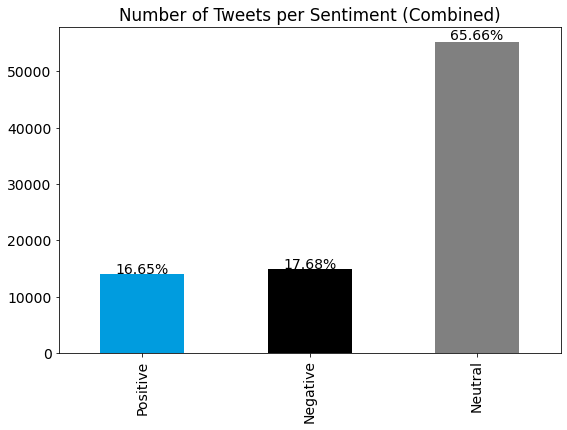

In [180]:
createBar(df['FrequentSentiment'].value_counts().sort_values(), 'Number of Tweets per Sentiment (Combined)', df)

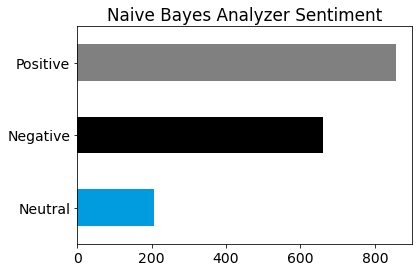

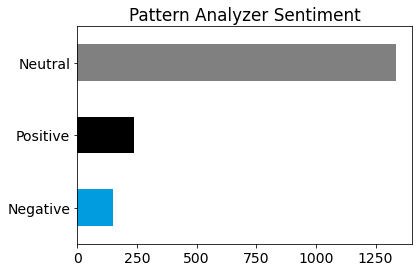

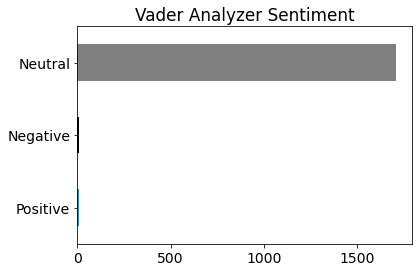

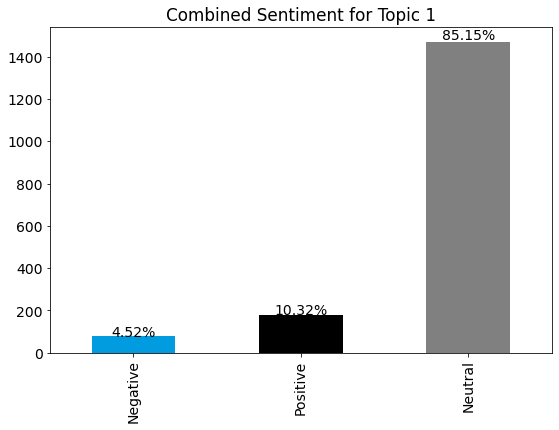

In [183]:
# Topic 1 Sentiment
df[df.Topic == 'Topic 1']['NaiveSentiment'].value_counts().sort_values().plot(kind = 'barh', color = ['#009CDF', 'black', 'grey'])
plt.title('Naive Bayes Analyzer Sentiment')
plt.show()
df[df.Topic == 'Topic 1']['PatternSentiment'].value_counts().sort_values().plot(kind = 'barh', color = ['#009CDF', 'black', 'grey'])
plt.title('Pattern Analyzer Sentiment')
plt.show()
df[df.Topic == 'Topic 1']['VaderSentiment'].value_counts().sort_values().plot(kind = 'barh', color = ['#009CDF', 'black', 'grey'])
plt.title('Vader Analyzer Sentiment')
plt.show()
createBar(df[df.Topic == 'Topic 1']['FrequentSentiment'].value_counts().sort_values(), 'Combined Sentiment for Topic 1', df[df.Topic == 'Topic 1'])

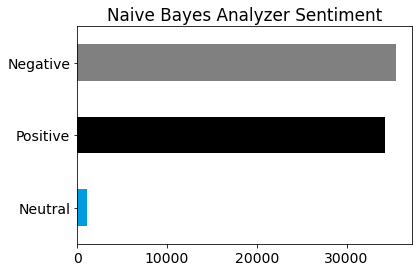

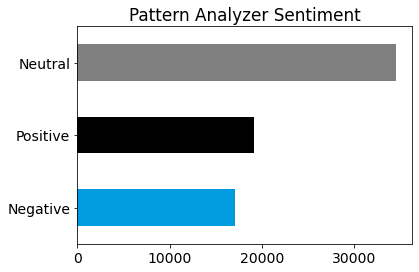

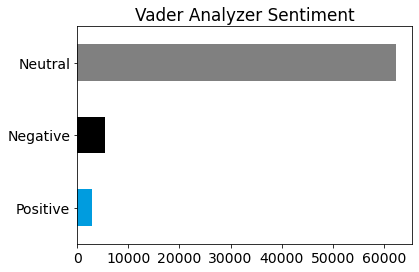

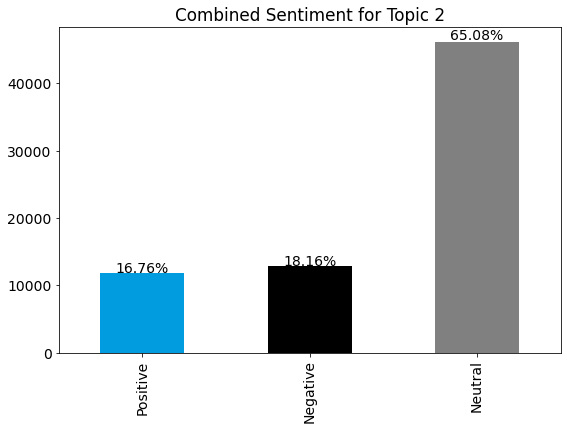

In [184]:
# Topic 2 Sentiment
df[df.Topic == 'Topic 2']['NaiveSentiment'].value_counts().sort_values().plot(kind = 'barh', color = ['#009CDF', 'black', 'grey'])
plt.title('Naive Bayes Analyzer Sentiment')
plt.show()
df[df.Topic == 'Topic 2']['PatternSentiment'].value_counts().sort_values().plot(kind = 'barh', color = ['#009CDF', 'black', 'grey'])
plt.title('Pattern Analyzer Sentiment')
plt.show()
df[df.Topic == 'Topic 2']['VaderSentiment'].value_counts().sort_values().plot(kind = 'barh', color = ['#009CDF', 'black', 'grey'])
plt.title('Vader Analyzer Sentiment')
plt.show()
createBar(df[df.Topic == 'Topic 2']['FrequentSentiment'].value_counts().sort_values(), 'Combined Sentiment for Topic 2', df[df.Topic == 'Topic 2'])

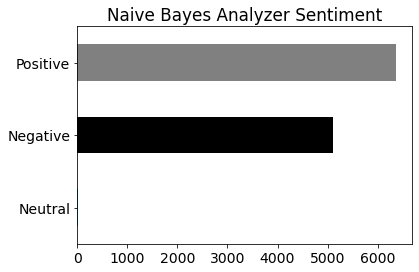

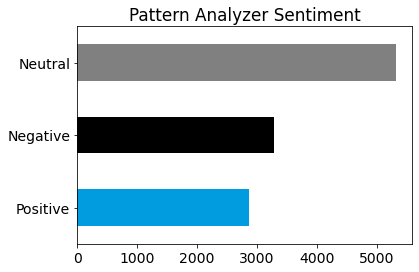

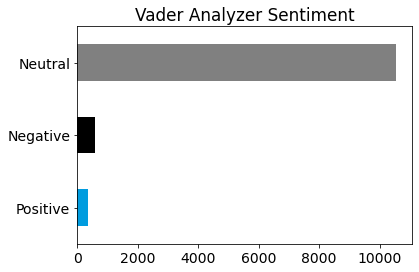

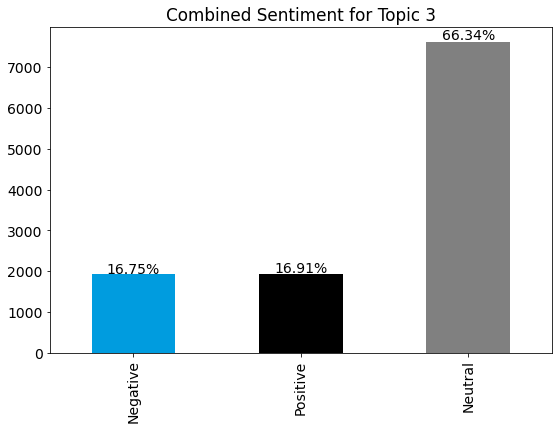

In [185]:
# Topic 3 Sentiment
df[df.Topic == 'Topic 3']['NaiveSentiment'].value_counts().sort_values().plot(kind = 'barh', color = ['#009CDF', 'black', 'grey'])
plt.title('Naive Bayes Analyzer Sentiment')
plt.show()
df[df.Topic == 'Topic 3']['PatternSentiment'].value_counts().sort_values().plot(kind = 'barh', color = ['#009CDF', 'black', 'grey'])
plt.title('Pattern Analyzer Sentiment')
plt.show()
df[df.Topic == 'Topic 3']['VaderSentiment'].value_counts().sort_values().plot(kind = 'barh', color = ['#009CDF', 'black', 'grey'])
plt.title('Vader Analyzer Sentiment')
plt.show()
createBar(df[df.Topic == 'Topic 3']['FrequentSentiment'].value_counts().sort_values(), 'Combined Sentiment for Topic 3', df[df.Topic == 'Topic 3'])

## Special Cases

In [52]:
before = df[df.Date < pd.Timestamp('2017-11-04 00:00:00')]
after = df[df.Date >= pd.Timestamp('2017-11-04 00:00:00')]

In [53]:
print(before['PatternSentiment'].value_counts())
print('')
print(before['VaderSentiment'].value_counts())
print('')
print(before['NaiveSentiment'].value_counts())
print('')
print(before['FrequentSentiment'].value_counts())

Neutral     21434
Positive    10833
Negative    10067
Name: PatternSentiment, dtype: int64

Neutral     37954
Negative     2789
Positive     1591
Name: VaderSentiment, dtype: int64

Negative    21010
Positive    20583
Neutral       741
Name: NaiveSentiment, dtype: int64

Neutral     28417
Negative     7312
Positive     6605
Name: FrequentSentiment, dtype: int64


In [54]:
print(after['PatternSentiment'].value_counts())
print('')
print(after['VaderSentiment'].value_counts())
print('')
print(after['NaiveSentiment'].value_counts())
print('')
print(after['FrequentSentiment'].value_counts())

Neutral     19760
Positive    11454
Negative    10477
Name: PatternSentiment, dtype: int64

Neutral     36658
Negative     3258
Positive     1775
Name: VaderSentiment, dtype: int64

Positive    20898
Negative    20264
Neutral       529
Name: NaiveSentiment, dtype: int64

Neutral     26757
Negative     7547
Positive     7387
Name: FrequentSentiment, dtype: int64


0.28844017186692505
0.08462309254972439
0.12675967307601513
0.7886185808097727
0.4928672515553286
0.5071327484446689
-0.008275209268338586


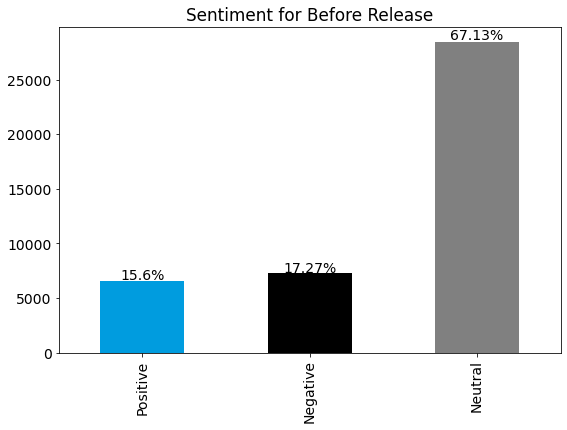

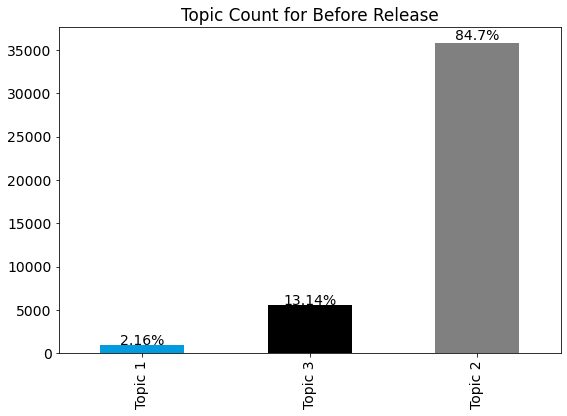

,tfidf
ios update,4.722875
iphone plus,4.769907
battery life,4.945285
new update,5.173325
new ios,5.182570
apple music,5.395702
iphone ios,5.458964
updated ios,5.546347
ios iphone,5.642102
apple watch,5.713198


In [202]:
# Before Release
print(before['Subjectivity'].mean())
print(before['PosVader'].mean())
print(before['NegVader'].mean())
print(before['NeuVader'].mean())
print(before['PosNaive'].mean())
print(before['NegNaive'].mean())
print(before['Polarity'].mean())

createBar(before['FrequentSentiment'].value_counts().sort_values(), 'Sentiment for Before Release', before)
createBar(before['Topic'].value_counts().sort_values(), 'Topic Count for Before Release', before)

tfidf = TfidfVectorizer(min_df = 2, max_df = 0.8, ngram_range=(2, 4))
tfidf.fit_transform(before['Clean'].values)
tfidf_table = pd.DataFrame(columns=['tfidf']).from_dict(dict(zip(tfidf.get_feature_names(), tfidf.idf_)), orient='index')
tfidf_table.columns = ['tfidf']
tfidf_table = tfidf_table.sort_values(by = ['tfidf'], ascending = True)
tfidf_table.head(10)

0.3084890290180693
0.09080732052481412
0.13399417140390124
0.7751985080713034
0.5033876076761519
0.4966123923238477
-0.00833404875279432


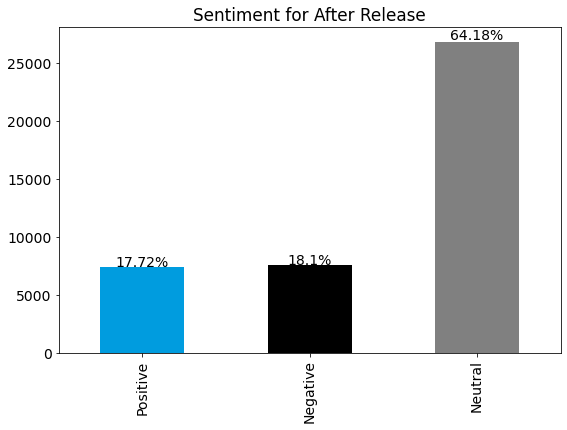

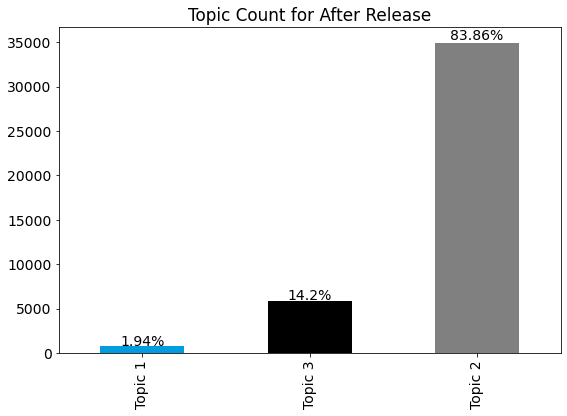

,tfidf
iphone plus,5.071392
ios update,5.281957
new iphone,5.425458
apple music,5.447749
high sierra,5.464278
battery life,5.474750
new update,5.590692
iphone ios,5.617041
updated phone,5.823934
updated ios,5.826924


In [201]:
# After Release
print(after['Subjectivity'].mean())
print(after['PosVader'].mean())
print(after['NegVader'].mean())
print(after['NeuVader'].mean())
print(after['PosNaive'].mean())
print(after['NegNaive'].mean())
print(after['Polarity'].mean())

createBar(after['FrequentSentiment'].value_counts().sort_values(), 'Sentiment for After Release', after)
createBar(after['Topic'].value_counts().sort_values(), 'Topic Count for After Release', after)

tfidf = TfidfVectorizer(min_df = 2, max_df = 0.8, ngram_range=(2, 4))
tfidf.fit_transform(after['Clean'].values)
tfidf_table = pd.DataFrame(columns=['tfidf']).from_dict(dict(zip(tfidf.get_feature_names(), tfidf.idf_)), orient='index')
tfidf_table.columns = ['tfidf']
tfidf_table = tfidf_table.sort_values(by = ['tfidf'], ascending = True)
tfidf_table.head(10)

0.29208654094673153
0.07375575519371136
0.09863391353172364
0.8276131386861318
0.5301255240128188
0.4698744759871816
0.011671181382719846


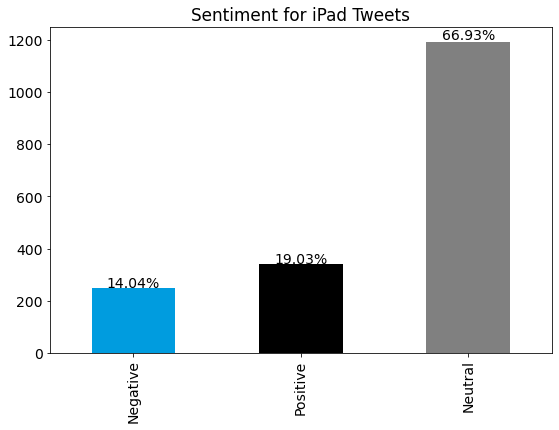

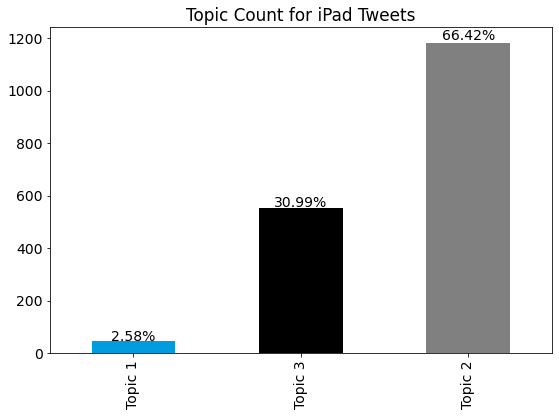

,tfidf
battery life,5.227395
app store,5.307438
latest update,5.394449
last update,5.712903
smart keyboard,5.777441
works fine,5.846434
stopped working,5.920542
software update,6.000585
photo library,6.087596
connect itunes,6.087596


In [200]:
checker = df[df.Clean.str.contains('ipad')]
stop = set(STOPWORDS).union({'ipad', 'pro', 'iphone', 'mini', 'apple', 'ios', 'new', 'even', 'though'})
print(checker['Subjectivity'].mean())
print(checker['PosVader'].mean())
print(checker['NegVader'].mean())
print(checker['NeuVader'].mean())
print(checker['PosNaive'].mean())
print(checker['NegNaive'].mean())
print(checker['Polarity'].mean())

createBar(checker['FrequentSentiment'].value_counts().sort_values(), 'Sentiment for iPad Tweets', checker)
createBar(checker['Topic'].value_counts().sort_values(), 'Topic Count for iPad Tweets', checker)

tfidf = TfidfVectorizer(min_df = 2, max_df = 0.8, ngram_range=(2, 4), stop_words = stop)
tfidf.fit_transform(checker['Clean'].values)
tfidf_table = pd.DataFrame(columns=['tfidf']).from_dict(dict(zip(tfidf.get_feature_names(), tfidf.idf_)), orient='index')
tfidf_table.columns = ['tfidf']
tfidf_table = tfidf_table.sort_values(by = ['tfidf'], ascending = True)
tfidf_table.head(10)

In [58]:
for i in checker[checker.Clean.str.contains('battery life')].text[:11]:
    print(i)

@165446 @AppleSupport I'm having the same problem with my iPad Air2, marked deterioration in battery life and charging time 🤔 #iOS11 @AppleSupport
@AppleSupport Yes I’m using the latest one. I’m having battery life issue since I’ve downloaded and updated it. This on iPhone &amp; iPad mini 2.
@AppleSupport Upgrading to 11.0.2 has killed my iPad battery life. Didn’t happen in iOS 10. Is there a fix coming soon?
#IOS11 had completely destroyed by battery life on an iPhone and iPad. Thank you very much @115858  @AppleSupport
@AppleSupport ever since I upgraded to IOS 11 on my iPad my battery has become horrible, instead of the normal super long battery life I get
hey @AppleSupport whats the deal w/battery life w/ ios11 I’m having to charge my phone and iPad multiple times a day w/out much use!
@AppleSupport @248319 This iPad mini 4 I got last June gets maybe 2 hours of battery life with 20% on the display approximately. Apps just close when using them
@AppleSupport new iOS wrecked my iPhon

0.30737557762112105
0.07067782062445563
0.11400995148650309
0.8153114815275504
0.4906201786229482
0.5093798213770503
-0.0007122741868840177


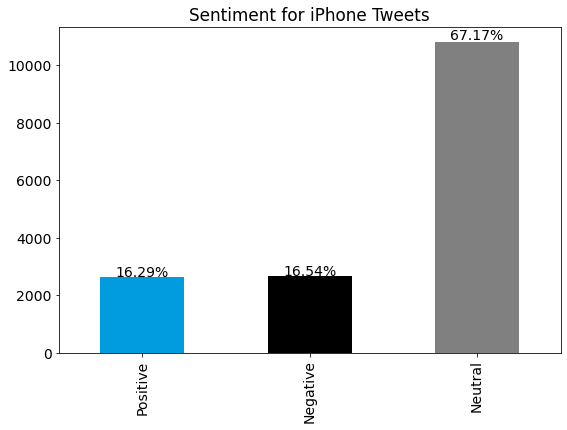

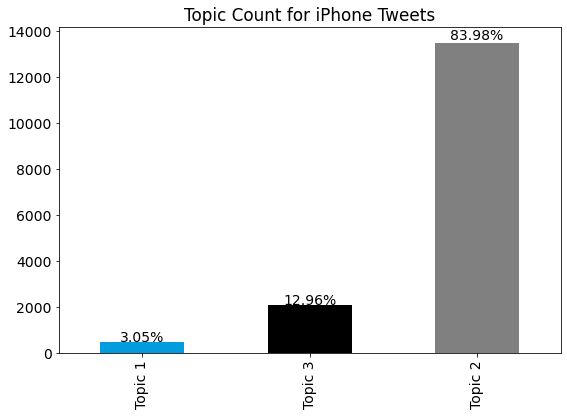

,tfidf
battery life,4.693805
latest update,5.221438
battery drain,5.833239
last update,5.864988
software update,5.873085
keeps freezing,5.881248
lock screen,5.923095
battery draining,5.931679
battery health,6.031309
battery drains,6.185460


In [199]:
checker = df[df.Clean.str.contains('iphone')]
stop = set(STOPWORDS).union({'ipad', 'pro', 'iphone', 'mini', 'ios', 'new', 'apple'})
print(checker['Subjectivity'].mean())
print(checker['PosVader'].mean())
print(checker['NegVader'].mean())
print(checker['NeuVader'].mean())
print(checker['PosNaive'].mean())
print(checker['NegNaive'].mean())
print(checker['Polarity'].mean())

createBar(checker['FrequentSentiment'].value_counts().sort_values(), 'Sentiment for iPhone Tweets', checker)
createBar(checker['Topic'].value_counts().sort_values(), 'Topic Count for iPhone Tweets', checker)

tfidf = TfidfVectorizer(min_df = 2, max_df = 0.8, ngram_range=(2, 4), stop_words = stop)
tfidf.fit_transform(checker['Clean'].values)
tfidf_table = pd.DataFrame(columns=['tfidf']).from_dict(dict(zip(tfidf.get_feature_names(), tfidf.idf_)), orient='index')
tfidf_table.columns = ['tfidf']
tfidf_table = tfidf_table.sort_values(by = ['tfidf'], ascending = True)
tfidf_table.head(10)

In [60]:
for i in checker[checker.Clean.str.contains('battery life')].text[:11]:
    print(i)

@AppleSupport Battery life on my iPhone 7 taken a hit after 11.0.2 update. It was much better on iOS 10
New iOS 11.0.2 on iPhone7+. Status bar no longer shows if Bluetooth connected &amp; does not show connected device battery life! @AppleSupport
@AppleSupport iphone 6. Didn’t need new IOS11 features, yet I upgraded + 2 updates yet Phone is slow, less battery life, typing delays, slow camera start.
.@AppleSupport entire family's iPhone 6s Pluses are draining battery life like second hand on a clock after ios11 update. Hope fix out soon.
@AppleSupport thanks so much for absolutely destroying my iPhone 7 battery life!!! The lone reason why I upgraded from a 6 to a 7!!! AWESOME
@171866 My battery life on iOS11 is 4 hours. iPhone 7+ @AppleSupport @116333
This new iPhone update is garbage! My battery life is getting murdered now @AppleSupport @115858
iPhoneSE wid 11.0.2 drains battery life swiftly and further the cellular hangs at times during num-pad dial. Throw some light @AppleSupport
@A

0.26770599946232887
0.06835443037974687
0.08235063291139247
0.8493037974683548
0.5754112338072224
0.42458876619277724
0.022387902182205995


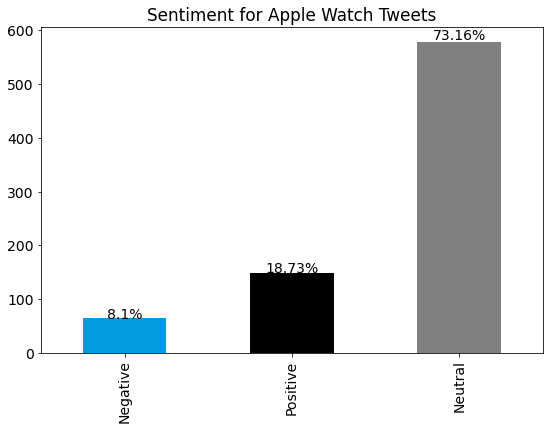

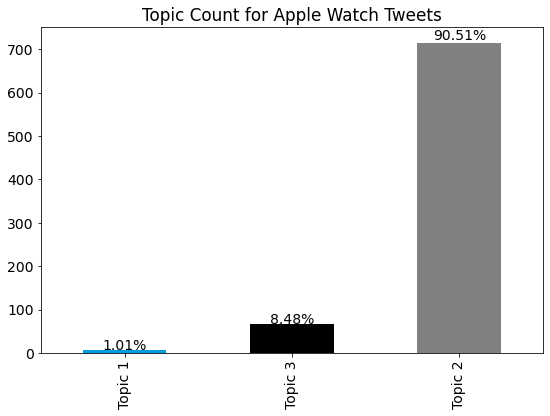

,tfidf
app icons,5.275403
activity app,5.370713
battery life,5.476073
last update,5.476073
workout app,5.593856
latest update,5.727388
music library,5.727388
music app,5.881538
activity data,5.881538
heart rate,5.881538


In [198]:
checker = df[df.Clean.str.contains('apple')][df.Clean.str.contains('watch')]
stop = set(STOPWORDS).union({'ipad', 'pro', 'iphone', 'mini', 'ios', 'new', 'apple', 'watch', 
                             'series', 'dont', 'know', 'even', 'though', 'watchos'})
print(checker['Subjectivity'].mean())
print(checker['PosVader'].mean())
print(checker['NegVader'].mean())
print(checker['NeuVader'].mean())
print(checker['PosNaive'].mean())
print(checker['NegNaive'].mean())
print(checker['Polarity'].mean())

createBar(checker['FrequentSentiment'].value_counts().sort_values(), 'Sentiment for Apple Watch Tweets', checker)
createBar(checker['Topic'].value_counts().sort_values(), 'Topic Count for Apple Watch Tweets', checker)

tfidf = TfidfVectorizer(min_df = 2, max_df = 0.8, ngram_range=(2, 4), stop_words = stop)
tfidf.fit_transform(checker['Clean'].values)
tfidf_table = pd.DataFrame(columns=['tfidf']).from_dict(dict(zip(tfidf.get_feature_names(), tfidf.idf_)), orient='index')
tfidf_table.columns = ['tfidf']
tfidf_table = tfidf_table.sort_values(by = ['tfidf'], ascending = True)
tfidf_table.head(10)

In [62]:
for i in checker[checker.Clean.str.contains('app icons')].text:
    print(i)

Hey @AppleSupport, why does my new Series 3 Apple Watch display blank app icons in notifications. Like this: https://t.co/A1wAkWPr7S
@AppleSupport some app icons doesn’t appear on my Apple Watch. Pls help. https://t.co/7SHXlHZAHR
@AppleSupport how come the app icons on my Apple Watch come up as blank white squares instead of the actual app icon?
@AppleSupport since my Apple Watch update it doesn’t display app icons when notifications appear just a black square any ideas?
@AppleSupport how come the app icons on my Apple Watch come up as blank white squares instead of the actual app icon?
@AppleSupport when are the app icons on Apple Watch being fixed? https://t.co/GPYpFuQmx3
@AppleSupport app icons not showing up on my Apple watch since iPhone update just some weird white thing
@AppleSupport some of my third party app icons aren’t loading on my Apple Watch?
@AppleSupport I am not getting app icons on my notifications. Just a wireframe. Any ideas on this? Apple Watch series 2 with latest

0.3240218013650765
0.07447112462006084
0.09264513677811552
0.8328837386018231
0.5734526440763084
0.42654735592369125
0.04113095723088121


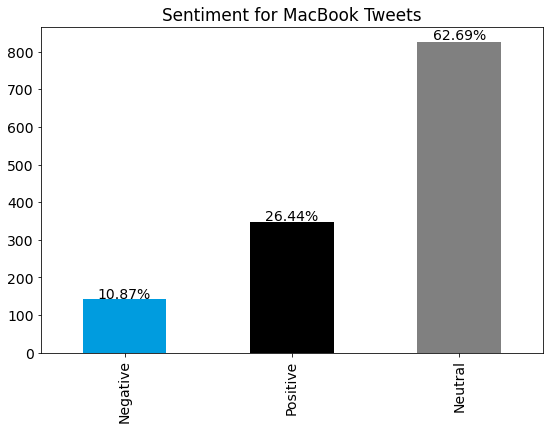

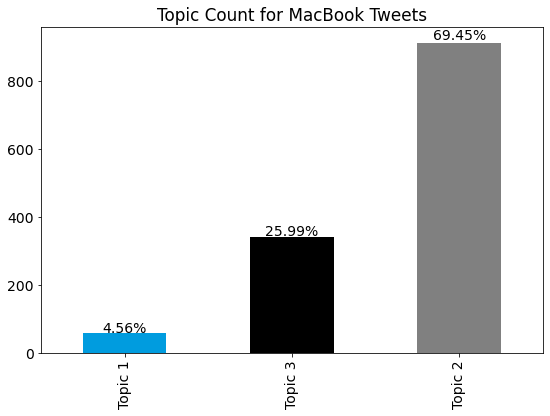

,tfidf
touch bar,5.238673
hard drive,5.238673
stopped working,5.544054
upgraded high,5.698205
updating high,5.698205
weeks ago,5.880527
genius bar,5.880527
month old,5.880527
keep getting,5.985887
logic board,5.985887


In [197]:
checker = df[df.Clean.str.contains('macbook')]
stop = set(STOPWORDS).union({'ipad', 'pro', 'iphone', 'mini', 'ios', 'new', 'apple', 'watch', 
                             'series', 'dont', 'know', 'even', 'though', 'watchos', 'macbook', 'air', 'pro',
                             'updated', 'sierra', 'macos', 'update'})
print(checker['Subjectivity'].mean())
print(checker['PosVader'].mean())
print(checker['NegVader'].mean())
print(checker['NeuVader'].mean())
print(checker['PosNaive'].mean())
print(checker['NegNaive'].mean())
print(checker['Polarity'].mean())

createBar(checker['FrequentSentiment'].value_counts().sort_values(), 'Sentiment for MacBook Tweets', checker)
createBar(checker['Topic'].value_counts().sort_values(), 'Topic Count for MacBook Tweets', checker)

tfidf = TfidfVectorizer(min_df = 2, max_df = 0.8, ngram_range=(2, 4), stop_words = stop)
tfidf.fit_transform(checker['Clean'].values)
tfidf_table = pd.DataFrame(columns=['tfidf']).from_dict(dict(zip(tfidf.get_feature_names(), tfidf.idf_)), orient='index')
tfidf_table.columns = ['tfidf']
tfidf_table = tfidf_table.sort_values(by = ['tfidf'], ascending = True)
tfidf_table.head(10)

In [64]:
for i in checker[checker.Clean.str.contains('hard drive')].text[:11]:
    print(i)

Hey @AppleSupport , I need help with installing macOS on my formatted hard drive on my MacBook Pro mid 2010 model. I've sent a DM
Soooo what do you do with your ssd hard drive when you need to upgrade your macbook pro? Like how do I transfer that? @AppleSupport
To "fix" my 12" Macbook keyboard, @AppleSupport had to replace the main logic board and wipe my hard drive. In doing so, they broke audio
When I plug an external hard drive into my new macbook pro it kills my internet... seriously @AppleSupport ? What the...
@AppleSupport I'm having trouble recovering my hard drive on my 2012 MacBook Pro and recovery mode isn't working for me ):
@AppleSupport Turns out my MacBook only restarts by itself and goes to Disk Utilities if I have my external hard drive connected.
@AppleSupport My external hard drive was also connected when I restarted my MacBook and the flashing question mark folder came up.
@AppleSupport my macbook pro needs a new hard drive but staff say you don't make them anymore😒


0.3248892422739457
0.06808747277453808
0.13049722475936187
0.8014160753179238
0.4528721482610927
0.5471278517389059
-0.013754881255162684


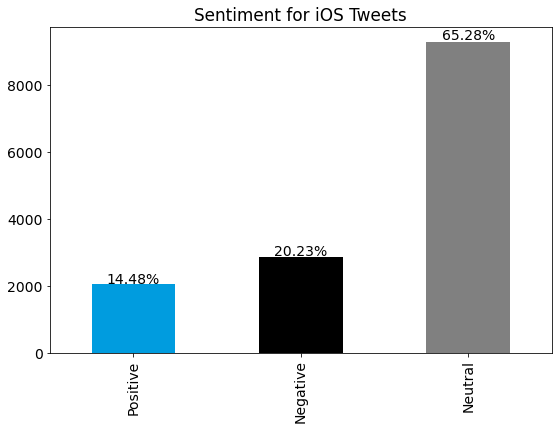

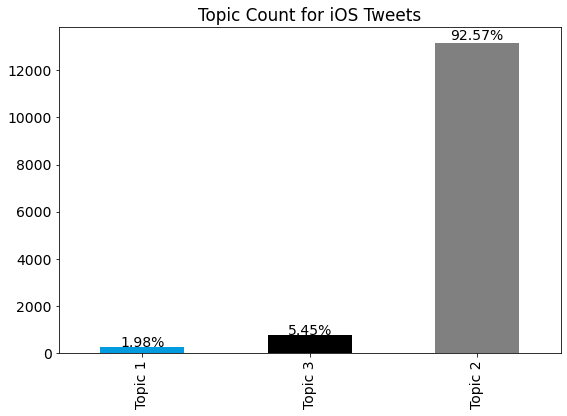

,tfidf
battery life,4.164794
battery drain,5.120971
battery draining,5.404333
lock screen,5.628915
draining battery,5.809799
phone keeps,5.809799
keeps freezing,5.818457
battery drains,5.818457
app store,6.097481
phone freezes,6.314894


In [196]:
checker = df[df.Clean.str.contains('ios')]
stop = set(STOPWORDS).union({'ipad', 'pro', 'iphone', 'mini', 'ios', 'new', 'apple', 'watch', 
                             'series', 'dont', 'know', 'even', 'though', 'watchos', 'macbook', 'air', 'pro',
                             'updated', 'sierra', 'macos', 'update', 'times', 'day', 'latest'})
print(checker['Subjectivity'].mean())
print(checker['PosVader'].mean())
print(checker['NegVader'].mean())
print(checker['NeuVader'].mean())
print(checker['PosNaive'].mean())
print(checker['NegNaive'].mean())
print(checker['Polarity'].mean())

createBar(checker['FrequentSentiment'].value_counts().sort_values(), 'Sentiment for iOS Tweets', checker)
createBar(checker['Topic'].value_counts().sort_values(), 'Topic Count for iOS Tweets', checker)

tfidf = TfidfVectorizer(min_df = 2, max_df = 0.8, ngram_range=(2, 4), stop_words = stop)
tfidf.fit_transform(checker['Clean'].values)
tfidf_table = pd.DataFrame(columns=['tfidf']).from_dict(dict(zip(tfidf.get_feature_names(), tfidf.idf_)), orient='index')
tfidf_table.columns = ['tfidf']
tfidf_table = tfidf_table.sort_values(by = ['tfidf'], ascending = True)
tfidf_table.head(10)

In [66]:
for i in checker[checker.Clean.str.contains('battery life')].text[:11]:
    print(i)

@AppleSupport my battery life has been horrible since I updated to iOS 11. Will there be a fix coming for this?
@AppleSupport just updated to ios11. Now I can only see time/battery life in certain apps as they cover each other. Even in standard apps
Yo @AppleSupport, wanna tell me why since iOS11 that I need to keep restoring my phone and my battery life is SHOCKING??? Nightmare!
@AppleSupport New update iOS 11.0.2   Is  not fixing the problems of battery life it is drain very fast
I'd argue that iOS 11.0.2 is even worse on battery life. @115858 @AppleSupport
@AppleSupport Just updated to iOS 11.0.2 and the phone gets really hot... and battery life is horrendus on a 7 Plus...
@AppleSupport Battery life on my iPhone 7 taken a hit after 11.0.2 update. It was much better on iOS 10
@115858 @AppleSupport iOS 11 sucks. Ever since I updated to it my phone runs super slow and my battery life has greatly decreased. #NotGood
@AppleSupport after updating iOS 11 battery life affecting too much,ple

0.23024427439829037
0.07495984329089125
0.07737708129285012
0.8476591576885406
0.6709624695925112
0.32903753040748757
0.0039577423882027245


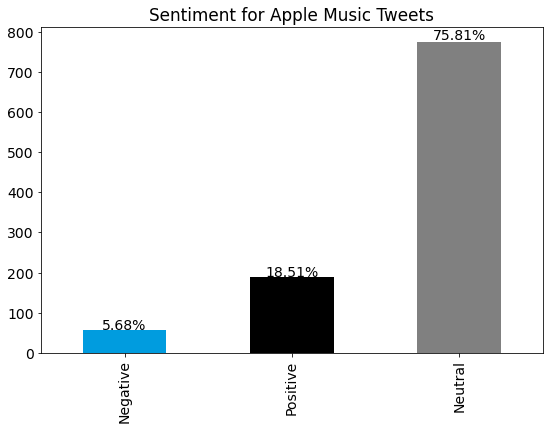

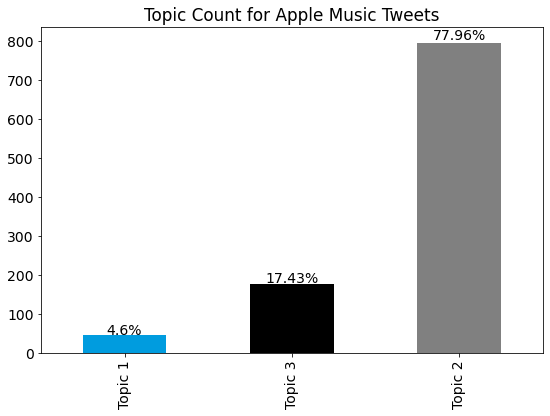

,tfidf
already member,5.221467
songs downloaded,5.290459
keeps crashing,5.364567
even though,5.364567
icloud library,5.444610
updated phone,5.444610
updated ios,5.531621
iphone plus,5.626932
free trial,5.626932
download songs,5.626932


In [203]:
checker = df[df.Clean.str.contains('apple music')]
stop = set(STOPWORDS).union({'apple', 'music'})
print(checker['Subjectivity'].mean())
print(checker['PosVader'].mean())
print(checker['NegVader'].mean())
print(checker['NeuVader'].mean())
print(checker['PosNaive'].mean())
print(checker['NegNaive'].mean())
print(checker['Polarity'].mean())

createBar(checker['FrequentSentiment'].value_counts().sort_values(), 'Sentiment for Apple Music Tweets', checker)
createBar(checker['Topic'].value_counts().sort_values(), 'Topic Count for Apple Music Tweets', checker)

tfidf = TfidfVectorizer(min_df = 2, max_df = 0.8, ngram_range=(2, 4), stop_words = stop)
tfidf.fit_transform(checker['Clean'].values)
tfidf_table = pd.DataFrame(columns=['tfidf']).from_dict(dict(zip(tfidf.get_feature_names(), tfidf.idf_)), orient='index')
tfidf_table.columns = ['tfidf']
tfidf_table = tfidf_table.sort_values(by = ['tfidf'], ascending = True)
tfidf_table.head(10)

In [68]:
for i in checker[checker.Clean.str.contains('already member')].text[:11]:
    print(i)

@AppleSupport Apple Music will not play for me. I’m signed in. When I try it directs me to join then says I’m already a member
@AppleSupport my apple music is not working. It is asking my to subscribe even though i am already a member. And yes you have taken my £££
@AppleSupport hi there. I’m already an Apple Music member but the app asking me to join again and when I do it says I’m already a member.
@AppleSupport Apple Music is not playing. I’m signed in. When I try it directs me to join then says I’m already a member. My lists are gone
@AppleSupport my apple music is not working. It keeps asking me to subscribe even though I am already a member. Please help!
@AppleSupport Apple music keeps asking me to sign up but I am already a member. It doesn't recognize my subscription.
@AppleSupport my Apple Music isn’t working, why? I am already a member.
@AppleSupport why is apple music telling me to subscribe, but then says that I’m already a member when I do so? Can’t play music at all
@1158

0.2015870829507193
0.0629621212121212
0.20171969696969702
0.7353219696969703
0.5223794538358891
0.477620546164111
0.05139075413223141


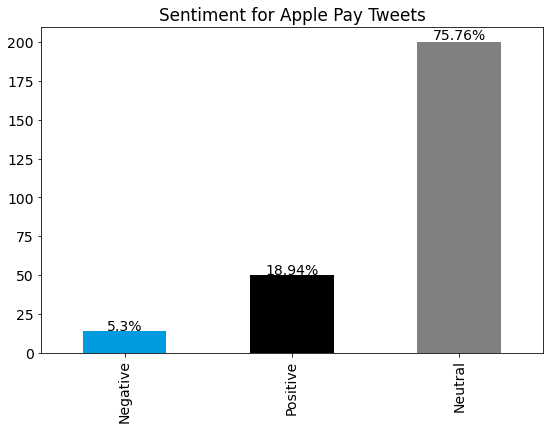

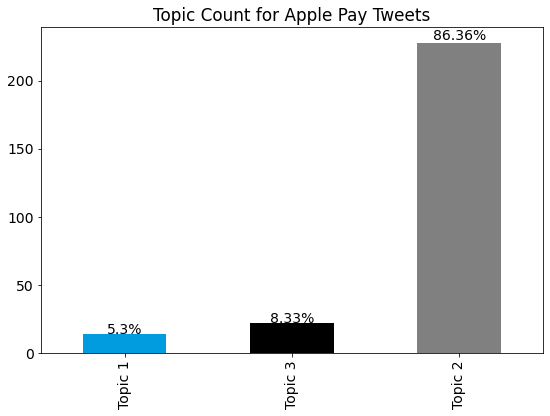

,tfidf
updated ios,3.535207
dont see,3.940672
cash card,4.094823
ios cash,4.181835
add card,4.382505
set cash,4.382505
see cash,4.500288
debit card,4.633820
cash feature,4.633820
card wallet,4.633820


In [193]:
checker = df[df.Clean.str.contains('apple pay')]
stop = set(STOPWORDS).union({'apple', 'pay'})
print(checker['Subjectivity'].mean())
print(checker['PosVader'].mean())
print(checker['NegVader'].mean())
print(checker['NeuVader'].mean())
print(checker['PosNaive'].mean())
print(checker['NegNaive'].mean())
print(checker['Polarity'].mean())

createBar(checker['FrequentSentiment'].value_counts().sort_values(), 'Sentiment for Apple Pay Tweets', checker)
createBar(checker['Topic'].value_counts().sort_values(), 'Topic Count for Apple Pay Tweets', checker)

tfidf = TfidfVectorizer(min_df = 2, max_df = 0.8, ngram_range=(2, 4), stop_words = stop)
tfidf.fit_transform(checker['Clean'].values)
tfidf_table = pd.DataFrame(columns=['tfidf']).from_dict(dict(zip(tfidf.get_feature_names(), tfidf.idf_)), orient='index')
tfidf_table.columns = ['tfidf']
tfidf_table = tfidf_table.sort_values(by = ['tfidf'], ascending = True)
tfidf_table.head(10)

In [70]:
for i in checker[checker.Clean.str.contains('updated ios')].text[:11]:
    print(i)

@AppleSupport I’ve updated to iOS 11.2, how do I use Apple Pay Cash?
@AppleSupport Hello! I just updated to iOS 11.2, but it is not offering me a way to set up the Apple Pay Cash Card.  Am I missing something? TIA https://t.co/uvkbkbtnZV
@AppleSupport My iPhone isn't giving me the Apple pay cash option even tho I updated to iOS 11.2
@AppleSupport just updated to iOS 11.2 and can’t find the new Apple Pay Cash 💳 settings. I’m In the USA 🇺🇸
@AppleSupport Hi I just updated to iOS 11.2 and Apple Pay Cash isn’t there. It said in release notes iOS 11.2 introduces Apple Pay Cash! Just wondering why it was left out...
@AppleSupport Hmm. Updated to iOS 11.2 but no option for Apple Pay Cash in “Wallet &amp; Apple Pay” in Settings. How do I enable it?
@AppleSupport I updated to iOS 11.2. I’m trying to set up Apple Pay cash but the Apple Pay cash options/settings doesn’t appear at all. All I see on display are my bank and credit cards. How do I solve this problem?
@AppleSupport updated to iOS 11.2 

0.34483399191248026
0.09463372093023252
0.12319767441860462
0.7821686046511627
0.5051677925977702
0.49483220740222955
0.03073316218665056


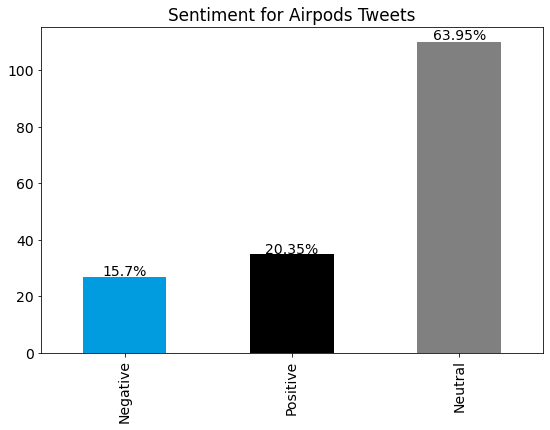

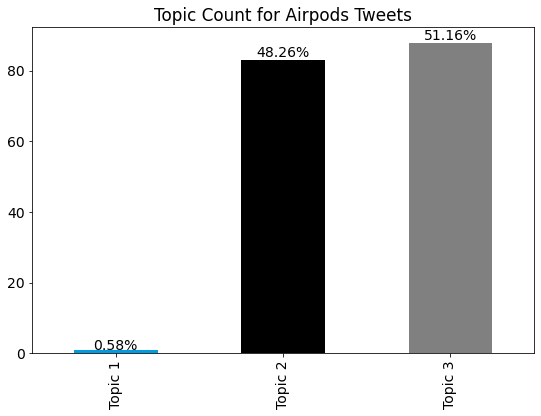

,tfidf
iphone plus,4.361532
left one,4.361532
apple watch,4.361532
charging case,4.543854
left airpod,4.766997
control center,4.766997
playing music,4.766997
anyone issues,4.766997
play audio,4.766997
apple products,4.766997


In [192]:
checker = df[df.Clean.str.contains('airpods')]
stop = set(STOPWORDS).union({'airpods'})
print(checker['Subjectivity'].mean())
print(checker['PosVader'].mean())
print(checker['NegVader'].mean())
print(checker['NeuVader'].mean())
print(checker['PosNaive'].mean())
print(checker['NegNaive'].mean())
print(checker['Polarity'].mean())

createBar(checker['FrequentSentiment'].value_counts().sort_values(), 'Sentiment for Airpods Tweets', checker)
createBar(checker['Topic'].value_counts().sort_values(), 'Topic Count for Airpods Tweets', checker)

tfidf = TfidfVectorizer(min_df = 2, max_df = 0.8, ngram_range=(2, 4), stop_words = stop)
tfidf.fit_transform(checker['Clean'].values)
tfidf_table = pd.DataFrame(columns=['tfidf']).from_dict(dict(zip(tfidf.get_feature_names(), tfidf.idf_)), orient='index')
tfidf_table.columns = ['tfidf']
tfidf_table = tfidf_table.sort_values(by = ['tfidf'], ascending = True)
tfidf_table.head(10)

In [72]:
for i in checker[checker.Clean.str.contains('left airpod')].text[:11]:
    print(i)

@AppleSupport My left AirPod seems to have died in the wake of 11.0.2. Restarting AirPods, re-pairing AirPods, and resetting network settings have done nothing. I bought these last week. Help!
@AppleSupport @115858 left AirPod trouble -&gt; disconnected from phone, now AirPods case not recognized. Light won't go amber no matter what! https://t.co/2HcAfEegac
@AppleSupport my left AirPods stops working every so often. It will not connect and will have a warning triangle on screen when I open the case. What should I do?
my out of box brand new Airpods is aint working good.. Left airpod not detecting charging no sound. initially had problem in pairin both with iphone x later paired with ipad pro n it got synced with icloud devices @AppleSupport @115858 #AirpodsNotWorking @116333


0.3322380952380952
0.05992
0.14806
0.79204
0.8135489102785296
0.18645108972147006
-0.04010119047619048


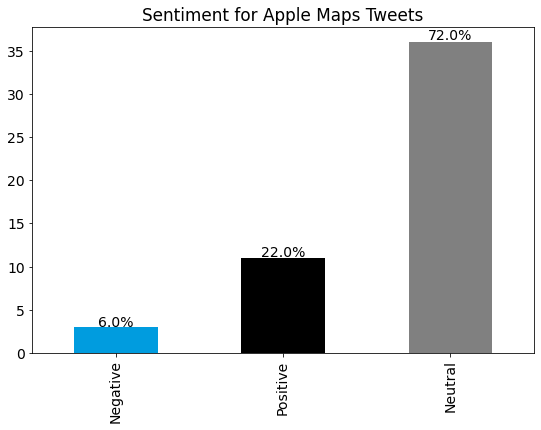

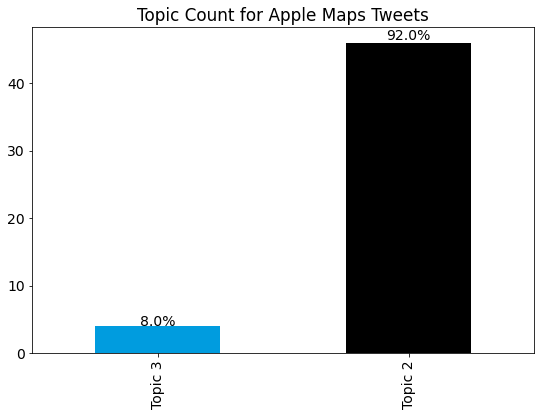

,tfidf
google maps,2.533930
apple map,3.322388
maps waze,3.322388
maps google,3.322388
apple maps google,3.545531
using apple maps,3.545531
using apple,3.545531
google maps waze,3.545531
maps google maps,3.545531
maps works,3.833213


In [191]:
checker = df[df.Clean.str.contains('apple map')]
stop = set(STOPWORDS).union({'apple map'})
print(checker['Subjectivity'].mean())
print(checker['PosVader'].mean())
print(checker['NegVader'].mean())
print(checker['NeuVader'].mean())
print(checker['PosNaive'].mean())
print(checker['NegNaive'].mean())
print(checker['Polarity'].mean())

createBar(checker['FrequentSentiment'].value_counts().sort_values(), 'Sentiment for Apple Maps Tweets', checker)
createBar(checker['Topic'].value_counts().sort_values(), 'Topic Count for Apple Maps Tweets', checker)

tfidf = TfidfVectorizer(min_df = 2, max_df = 0.8, ngram_range=(2, 4), stop_words = stop)
tfidf.fit_transform(checker['Clean'].values)
tfidf_table = pd.DataFrame(columns=['tfidf']).from_dict(dict(zip(tfidf.get_feature_names(), tfidf.idf_)), orient='index')
tfidf_table.columns = ['tfidf']
tfidf_table = tfidf_table.sort_values(by = ['tfidf'], ascending = True)
tfidf_table.head(10)

In [76]:
for i in checker[checker.Clean.str.contains('google maps')].text[:11]:
    print(i)

@AppleSupport why the location isn’t accurate on apple maps as well as on google maps post ios11 update?
Hey @AppleSupport! GPS isn’t working on iOS 11.0.3 iPhone 8. Goes in &amp; out when I’m driving using Waze, Google maps, or Apple Maps. Help!
@AppleSupport i can’t seem to search anywhere in Apple Maps. I’ve searched in Google Maps and it works fine. I’ve tried rebooting too https://t.co/vkd7cqy6ne
@AppleSupport It happens on all GPS centric apps:Apple Maps, Google Maps, and Waze.
@AppleSupport Intermittent issues “no gps at this location” get this at multiple locations using multiple apps Apple maps/google maps/Waze
@677401 @AppleSupport Not just iPhoneX. My iPhone 7 Plus gps no longer working correctly. Map thinks I am 200 feet behind where I really am, so I miss every turn. It's not an app problem, but iOS problem, effects Apple Maps, Google Maps, and Waze the same.
@AppleSupport - Team, I’m unable to view the places I visited on google maps timeline. Need fix for it. I switched 

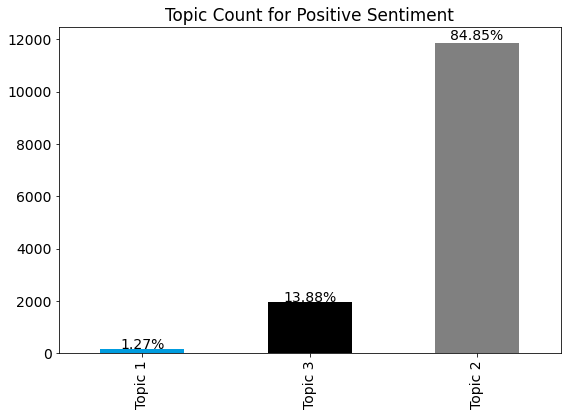

,tfidf
high sierra,4.243694
new iphone,4.611418
new ios,4.922295
new phone,5.099575
new update,5.171034
latest ios,5.253008
iphone plus,5.263109
apple music,5.315204
macbook pro,5.458716
ios update,5.483717


In [189]:
checker = df[df.FrequentSentiment == 'Positive']
createBar(checker['Topic'].value_counts().sort_values(), 'Topic Count for Positive Sentiment', checker)
tfidf = TfidfVectorizer(min_df = 2, max_df = 0.8, ngram_range=(2, 4))
tfidf.fit_transform(checker['Clean'].values)
tfidf_table = pd.DataFrame(columns=['tfidf']).from_dict(dict(zip(tfidf.get_feature_names(), tfidf.idf_)), orient='index')
tfidf_table.columns = ['tfidf']
tfidf_table = tfidf_table.sort_values(by = ['tfidf'], ascending = True)
tfidf_table.head(10)

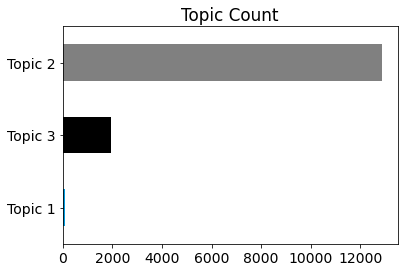

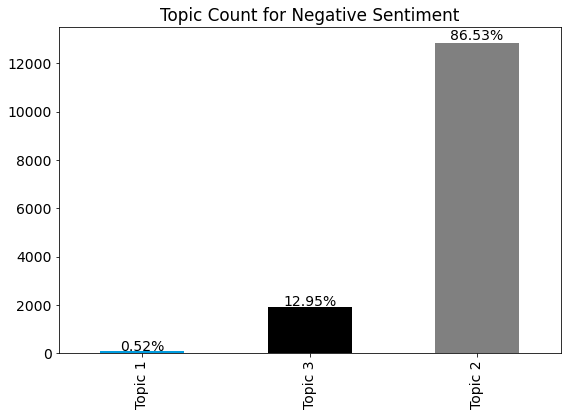

,tfidf
battery life,4.262548
ios update,4.556695
new update,4.834987
iphone plus,4.975217
new ios,5.181478
update phone,5.525024
hard reset,5.609216
new iphone,5.708589
updated ios,5.731231
iphone battery,5.746616


In [188]:
checker = df[df.FrequentSentiment == 'Negative']
createBar(checker['Topic'].value_counts().sort_values(), 'Topic Count for Negative Sentiment', checker)
tfidf = TfidfVectorizer(min_df = 2, max_df = 0.8, ngram_range=(2, 4))
tfidf.fit_transform(checker['Clean'].values)
tfidf_table = pd.DataFrame(columns=['tfidf']).from_dict(dict(zip(tfidf.get_feature_names(), tfidf.idf_)), orient='index')
tfidf_table.columns = ['tfidf']
tfidf_table = tfidf_table.sort_values(by = ['tfidf'], ascending = True)
tfidf_table.head(10)

In [219]:
#for i in before[before.Clean.str.contains('updated ios')].text[:11]:
#    print(i)
    
for i in before[before.FrequentSentiment == 'Positive'].text[:11]:
    print(i)

@AppleSupport I have to restart my phone every single time I want to make a call because the new update messed up with the handset!!!! FIX THIS BUG
@115858 @AppleSupport notifications handlin wen locked was a lot better earlier.wifi autoconnects itself all time.#ios11update
@AppleSupport Nope. Just the exclamation mark saying not delivered. Only to android phones. iMessage works perfect
@AppleSupport No sir. No delete badge appear on that particular icon. However a restart does the job. Thanks for the help though.
@AppleSupport I really dislike this new update, it keeps freezing my phone. And the music app doesn’t show the music on my phone
@AppleSupport @115858 too many issues with 11.0.1. Phone worked fine with iOS 10. I have to hard reset this device 10 / day ...pls fix this!
@AppleSupport I get these. I get the code on my phone too. But no prompt on my laptop. Please help. It's been like this for many months now https://t.co/HAWmCSS8S8
@AppleSupport Everything is original, nothing 

In [218]:
#for i in after[after.Clean.str.contains('updated ios')].text[:11]:
    #print(i)
    
for i in after[after.FrequentSentiment == 'Positive'].text[:11]:
    print(i)

@AppleSupport Yup. Everything lags. All the apple apps. Messaging, email, music, etc. it’s a piece of shit to be honest and y’all shouldn’t be hyped.
@115858 @AppleSupport after installing new update ios11.1, phone is dead slow and running like a zombie. Kindly act on it and change ios11
@AppleSupport I'm trying to set up my new X with a backup on my computer and it's requiring a password to access the backup.
@AppleSupport what the hell?why would I recieve a notification like this on my iPhone saying that they are conducting tests to win ? #alert https://t.co/KD8NZ0FuC4
@AppleSupport hi, do you know when a reserve and pickup option will be available in the US for the iPhone x?
I️ have no idea what’s going on but I️ have had enough of it @AppleSupport y’all are ruining my chances of finding a nice boy fix it https://t.co/3U767aZpPU
Yay I️ have the cool new emojis, that’s nice. But I️ can’t type the letter ‘l’ 
Get it together @AppleSupport
@474865 @AppleSupport I got my purchase in, co